In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
preds = pd.read_csv('regression/DeepPTS-MIC_test.csv').sort_values(by='pred')
preds = preds.drop(columns = ['Unnamed: 0',])
preds

,sequence,label,species,pred
511,AWCARVCYRGICYRRCR,-0.028483,Escherichia coli,-1.503306
2186,KWCFRVCYRGICYARCR,-1.242273,Bacillus subtilis,-1.279701
1864,VDKPPYLPRPRPPRRIYKRG,-0.976299,Pseudomonas aeruginosa,-1.140107
1809,VDKPPYLPRPRFPRRIYNRG,-0.999635,Pseudomonas aeruginosa,-1.137793
2315,AWCARVCYRGICYRRCR,0.874607,Bacillus subtilis,-1.114560
...,...,...,...,...
2551,VLNENLAA,3.397940,Klebsiella pneumoniae,3.106923
639,VLNENLAA,3.118595,Escherichia coli,3.152355
2047,VLNENLL,3.096910,Salmonella enterica,3.253964
2119,VLNENLAA,3.397940,Salmonella enterica,3.379248


In [11]:
avg_preds = preds.groupby('sequence').mean()
avg_preds = avg_preds.sort_values(by='pred')

In [12]:
avg_preds[-100:]

,label,pred
sequence,,
MITISTMLQFGLFLIALIGLVIKLIELSNKK,1.574031,1.864220
KLLPSVVGLFKKKKQ,1.698970,1.868338
GVSKILHSAGKFGKAFLGEIMKS,2.044023,1.872137
CAIEHMRTPLKPFSFGPPYNL,0.544068,1.876316
LLLLLW,1.150515,1.876796
...,...,...
FVNVLDKIR,2.709270,2.783924
VLNENLAA,2.922661,2.870045
CWTASIPPRPC,2.909933,2.914580


In [13]:
active_seq = avg_preds[:100].index.to_list()

In [14]:
inactive_seq = avg_preds[-100:].index.to_list()

# Attention 얻기

In [15]:
import numpy as np
import torch
import torch.nn as nn

import os
import random
import copy

from transformers import EsmTokenizer, EsmModel

import torch
import torch.nn as nn

from sklearn import metrics
from tqdm.auto import tqdm, trange

import torch.optim as optim
import math
from torch.optim.lr_scheduler import _LRScheduler

import os
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [16]:
device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
NUM_THREADS = 0
NUM_EPOCHS = 50

tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")

In [17]:
class RegressionModel(nn.Module):
    def __init__(self, hidden_feat, pooling = None, pretrained_model='pretraining/model_K/pepESM_90_50K'):
        super(RegressionModel, self).__init__()
        self.bert = EsmModel.from_pretrained(pretrained_model, output_attentions=True)
        self.pooling = pooling
        
        self.genome_linear = nn.Sequential(nn.Linear(340, 256),
                                           nn.ReLU(),
                                           nn.Linear(256, 128))
        
        self.peptide_linear = nn.Sequential(nn.Linear(480, 256))
        
        if hidden_feat == None:
            self.linear = nn.Sequential(nn.Linear(384, 1))
        else:
            self.linear = nn.Sequential(nn.Linear(384, hidden_feat),
                                        nn.ReLU(),
                                        nn.Linear(hidden_feat, hidden_feat),
                                        nn.ReLU(),
                                        nn.Linear(hidden_feat, 1))
        
    def forward(self, input_ids, attention_mask, genome_feat):
        embedding = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        if self.pooling == 'mean':
            hidden = torch.sum((embedding * attention_mask.unsqueeze(-1)), dim =1) / torch.sum(attention_mask, dim=1).unsqueeze(-1)
        elif self.pooling == 'sum': #'sum'
            hidden = torch.sum((embedding * attention_mask.unsqueeze(-1)), dim =1)
        elif self.pooling == 'CLS':
            hidden = embedding[:, 0, :]
        
        hidden = self.peptide_linear(hidden)
        genome_feat = self.genome_linear(genome_feat)
            
        in_feats = torch.cat([hidden, genome_feat], dim=1)
        predict = self.linear(in_feats)
        return predict.squeeze()

In [18]:
ESM_35M_regression = RegressionModel(hidden_feat = 256, pooling = 'CLS')
ESM_35M_regression.load_state_dict(torch.load('regression/saved_models/pepESM_90_35_species_500.pth'), strict=False)

ESM_35M_regression = ESM_35M_regression.bert # BERT 부분만 불러오기

Some weights of the model checkpoint at pretraining/model_K/pepESM_90_50K were not used when initializing EsmModel: ['esm.contact_head.regression.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'esm.contact_head.regression.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at pretraining/model_K/pepESM_90_50K and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN

# 예시 서열에 대한 attention 값 불러오기

In [21]:
sequence = 'GVSKILHSAGKFGKAFLGEIMKS' # 길이 23짜리 서열

inputs = tokenizer.encode(sequence, return_tensors='pt')

outputs = ESM_35M_regression(inputs)

In [22]:
inputs

tensor([[ 0,  6,  7,  8, 15, 12,  4, 21,  8,  5,  6, 15, 18,  6, 15,  5, 18,  4,
          6,  9, 12, 20, 15,  8,  2]])

In [23]:
outputs # Last_hidden_state, pooler_output, attentions

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2514, -0.0705, -0.0167,  ...,  0.0391, -0.4312, -0.0209],
         [-0.0875, -0.0733, -0.0417,  ..., -0.0182, -0.4814, -0.0082],
         [-0.1075, -0.1389, -0.0745,  ..., -0.1176, -0.1916, -0.0225],
         ...,
         [-0.0746,  0.0538, -0.1468,  ..., -0.0866, -0.0921,  0.0341],
         [ 0.0100,  0.0237,  0.0631,  ..., -0.0084, -0.5113, -0.0174],
         [-0.0574,  0.0078, -0.0570,  ...,  0.0191, -0.5388, -0.0214]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 1.0598e-01, -1.7216e-01, -1.1362e-01, -2.9214e-02, -6.3917e-02,
          4.4267e-02, -3.0751e-02, -6.6179e-02,  5.6136e-02,  4.3830e-02,
         -5.9811e-02, -9.1667e-02, -9.1124e-02, -1.1737e-01, -4.2373e-02,
          4.3235e-02,  1.0907e-01, -8.0613e-02, -1.1015e-01, -8.4347e-02,
          1.2244e-02, -2.4617e-02, -2.6855e-02,  3.0385e-02,  9.2517e-02,
          8.6443e-02,  4.7153e-02,  3.1119e-02, -9.9613e-02,  1.541

In [24]:
all_attention = outputs[-1]

In [26]:
len(all_attention)

12

In [27]:
all_attention[0].shape

torch.Size([1, 20, 25, 25])

In [28]:
input_sequence = list(sequence)
input_sequence.insert(0, '<cls>')
input_sequence.append('<eos>')

In [29]:
input_sequence

['<cls>',
 'G',
 'V',
 'S',
 'K',
 'I',
 'L',
 'H',
 'S',
 'A',
 'G',
 'K',
 'F',
 'G',
 'K',
 'A',
 'F',
 'L',
 'G',
 'E',
 'I',
 'M',
 'K',
 'S',
 '<eos>']

In [31]:
all_attention[0][0][0].shape

torch.Size([25, 25])

In [41]:
df = pd.DataFrame(all_attention[0][0][0].detach().numpy())
df.index = input_sequence
df.columns = input_sequence
df

,<cls>,G,V,S,K,I,L,H,S,A,...,A,F,L,G,E,I,M,K,S,<eos>
<cls>,0.064147,0.020960,0.071957,0.028631,0.029438,0.064866,0.022477,0.056468,0.025297,0.094655,...,0.106919,0.016069,0.012424,0.014958,0.025880,0.032053,0.014257,0.044927,0.013601,0.101955
G,0.075113,0.026853,0.069437,0.041586,0.029002,0.065772,0.034025,0.036784,0.029092,0.061735,...,0.089044,0.019064,0.014869,0.015217,0.023947,0.017291,0.020180,0.041775,0.016531,0.123628
V,0.119225,0.020703,0.029424,0.032318,0.023255,0.110083,0.023753,0.043289,0.032306,0.085317,...,0.080605,0.015800,0.011673,0.016842,0.021098,0.060941,0.009939,0.037686,0.016173,0.076952
S,0.085795,0.020182,0.069341,0.038208,0.018974,0.133377,0.027212,0.029232,0.029566,0.062770,...,0.083859,0.018520,0.012490,0.020324,0.024285,0.039309,0.015039,0.030252,0.013714,0.100597
K,0.074265,0.034339,0.040076,0.034206,0.011876,0.100520,0.031373,0.049564,0.033639,0.055028,...,0.062953,0.023904,0.018570,0.030659,0.034790,0.057845,0.017226,0.016561,0.017523,0.116809
I,0.040327,0.029385,0.058418,0.045478,0.028461,0.041985,0.033586,0.034578,0.038323,0.080271,...,0.111372,0.020963,0.016475,0.023908,0.026306,0.023190,0.012526,0.041161,0.019452,0.114665
L,0.044617,0.027562,0.089383,0.047643,0.027912,0.057850,0.031050,0.031247,0.034386,0.074905,...,0.106705,0.019038,0.015293,0.024306,0.023766,0.020040,0.012398,0.044057,0.016409,0.102919
H,0.023941,0.016555,0.099225,0.035459,0.008966,0.215534,0.035889,0.053596,0.027460,0.040460,...,0.062693,0.020527,0.022686,0.033510,0.020598,0.032374,0.021610,0.015980,0.010878,0.090479
S,0.050725,0.024550,0.043851,0.052432,0.020811,0.118213,0.038897,0.026669,0.041630,0.047366,...,0.071916,0.028996,0.019834,0.030474,0.026061,0.040665,0.018999,0.027565,0.019422,0.113377
A,0.023501,0.030444,0.077855,0.061586,0.022920,0.073746,0.042486,0.027325,0.045786,0.043864,...,0.072228,0.030289,0.024223,0.034246,0.024485,0.029759,0.019645,0.031954,0.019989,0.110855


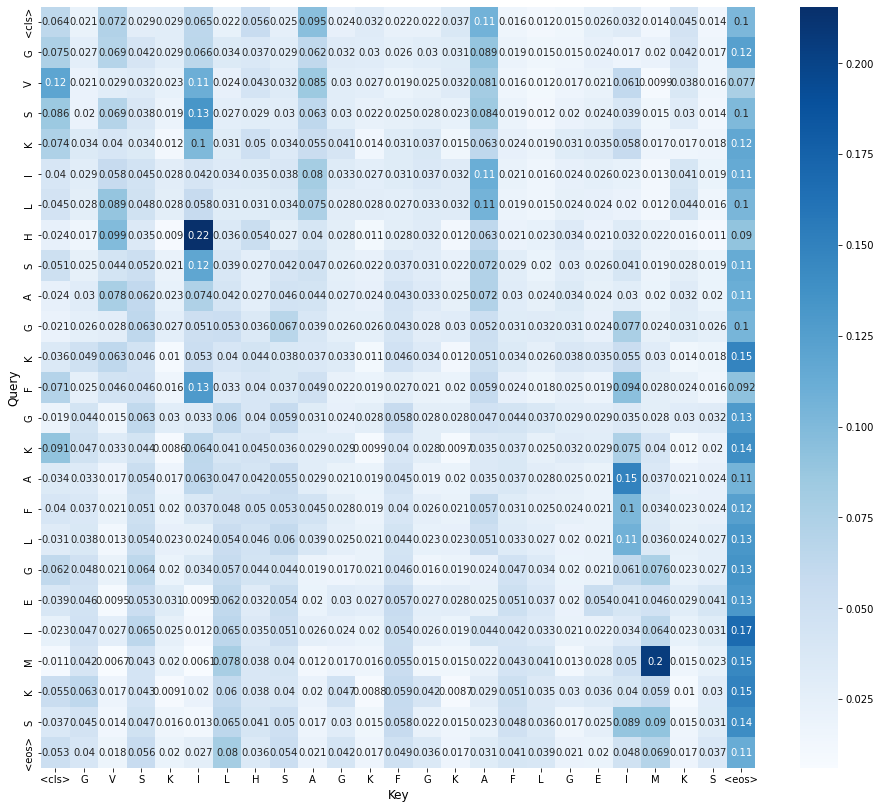

In [45]:
plt.figure(figsize=(16,14))
sns.heatmap(df, annot=True, cmap='Blues')
plt.xlabel('Key', fontsize = 12)
plt.ylabel('Query', fontsize = 12)
plt.show()

In [104]:
def get_attention(seq):
    inputs = tokenizer.encode(seq, return_tensors='pt')
    all_attention = ESM_35M_regression(inputs)[-1]

    layer9_attention = all_attention[9][0].detach().numpy()
    layer10_attention = all_attention[10][0].detach().numpy()
    layer11_attention = all_attention[11][0].detach().numpy()
    
    output_attention = np.stack([layer9_attention, layer10_attention, layer11_attention])
    
    # input_sequence = list(seq)
    # input_sequence.insert(0, '<cls>')
    # input_sequence.append('<eos>')
    
    return output_attention

In [107]:
active_attentions = []
inactive_attentions = []

for seq in active_seq:
    attention = get_attention(seq)
    active_attentions.append(attention)
    
for seq in inactive_seq:
    attention = get_attention(seq)
    inactive_attentions.append(attention)    

# Active

In [149]:
# layer 9, 10, 11번의 Head 20개 std 확인 (Active)
active_layer9_std_dict = {}
active_layer10_std_dict = {}
active_layer11_std_dict = {}

for i in range(20):
    active_layer9_std_dict[i] = []
    active_layer10_std_dict[i] = []
    active_layer11_std_dict[i] = []

for attention in active_attentions:
    active_layer9_attention = attention[0]
    active_layer10_attention = attention[1]
    active_layer11_attention = attention[2]
    for i in range(20):
        active_layer9_std_dict[i].append(active_layer9_attention[i].std())
        active_layer10_std_dict[i].append(active_layer10_attention[i].std())
        active_layer11_std_dict[i].append(active_layer11_attention[i].std())
        
inactive_layer9_std_dict = {}
inactive_layer10_std_dict = {}
inactive_layer11_std_dict = {}

for i in range(20):
    inactive_layer9_std_dict[i] = []
    inactive_layer10_std_dict[i] = []
    inactive_layer11_std_dict[i] = []

for attention in inactive_attentions:
    inactive_layer9_attention = attention[0]
    inactive_layer10_attention = attention[1]
    inactive_layer11_attention = attention[2]
    for i in range(20):
        inactive_layer9_std_dict[i].append(inactive_layer9_attention[i].std())
        inactive_layer10_std_dict[i].append(inactive_layer10_attention[i].std())
        inactive_layer11_std_dict[i].append(inactive_layer11_attention[i].std())

In [184]:
box_pairs = [((0, 'active'), (0, 'inactive')),
             ((1, 'active'), (1, 'inactive')),
             ((2, 'active'), (2, 'inactive')),
             ((3, 'active'), (3, 'inactive')),
             ((4, 'active'), (4, 'inactive')),
             ((5, 'active'), (5, 'inactive')),
             ((6, 'active'), (6, 'inactive')),
             ((7, 'active'), (7, 'inactive')),
             ((8, 'active'), (8, 'inactive')),
             ((9, 'active'), (9, 'inactive')),
             ((10, 'active'), (10, 'inactive')),
             ((11, 'active'), (11, 'inactive')),
             ((12, 'active'), (12, 'inactive')),
             ((13, 'active'), (13, 'inactive')),
             ((14, 'active'), (14, 'inactive')),
             ((15, 'active'), (15, 'inactive')),
             ((16, 'active'), (16, 'inactive')),
             ((17, 'active'), (17, 'inactive')),
             ((18, 'active'), (18, 'inactive')),
             ((19, 'active'), (19, 'inactive')),
             ]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_active v.s. 9_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=8.520e-02
10_active v.s. 10_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.686e+00
11_active v.s. 11_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=6.507e-05 stat=-4.791e+00
12_active v.s. 12_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.062e-03 stat=-4.136e+00
13_active v.s. 13_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=5.086e-04 stat=-4.315e+00
14_active v.s. 14_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=2.013e-04 stat=-4.542e+00
15_active v.s. 15_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=4.71

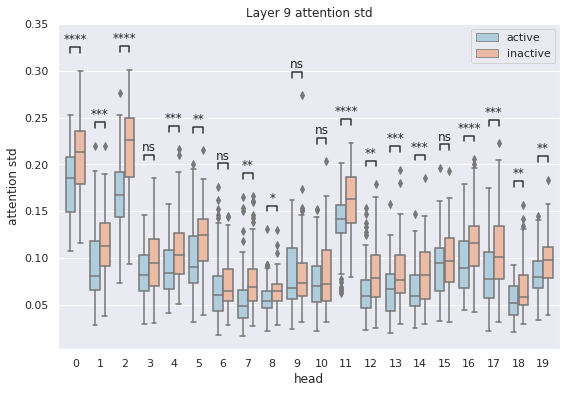

In [194]:
import seaborn as sns
from statannot import add_stat_annotation

def df_transformation(df):
    temp_list = []
    for col in df.columns:
        temp = pd.DataFrame(df[col])
        temp.columns = ['attention std']
        temp['head'] = col
        temp_list.append(temp)
    return pd.concat(temp_list, axis=0)

sns.set(rc={"figure.figsize":(9, 6)})

df_active = pd.DataFrame(active_layer9_std_dict)
df_inactive = pd.DataFrame(inactive_layer9_std_dict)

df_active = df_transformation(df_active)
df_inactive = df_transformation(df_inactive)

df_active['activity'] = 'active'
df_inactive['activity'] = 'inactive'

df = pd.concat([df_active, df_inactive]).reset_index(drop=True)

hue_order = ['active', 'inactive']

ax = sns.boxplot(x = 'head', y = 'attention std', hue = 'activity', hue_order = hue_order, palette = 'RdBu_r', data = df)

plt.title('Layer 9 attention std')
plt.legend()

add_stat = add_stat_annotation(ax, data=df.reset_index(drop=True), x='head', y='attention std', hue='activity', hue_order=hue_order, order=None,
                                       box_pairs=box_pairs,
                                       test='t-test_welch', text_format='star',
                                       loc='inside', verbose=2)

plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_active v.s. 9_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.864e-03 stat=-3.990e+00
10_active v.s. 10_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.382e+00
11_active v.s. 11_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=3.049e-04 stat=-4.436e+00
12_active v.s. 12_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=3.124e-04 stat=-4.430e+00
13_active v.s. 13_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=6.714e-06 stat=-5.282e+00
14_active v.s. 14_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=6.140e-04 stat=-4.267e+00
15_active v.s. 15_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=2.1

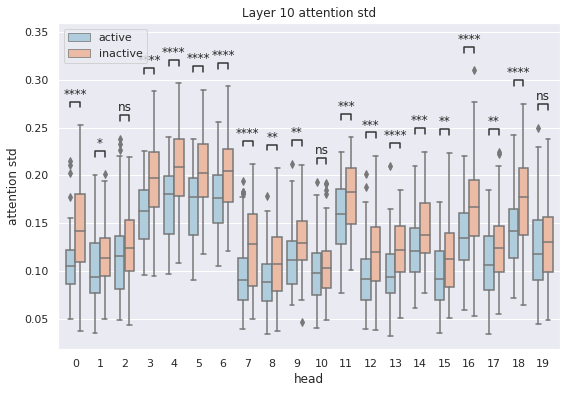

In [195]:
df_active = pd.DataFrame(active_layer10_std_dict)
df_inactive = pd.DataFrame(inactive_layer10_std_dict)

df_active = df_transformation(df_active)
df_inactive = df_transformation(df_inactive)

df_active['activity'] = 'active'
df_inactive['activity'] = 'inactive'

df = pd.concat([df_active, df_inactive]).reset_index(drop=True)

hue_order = ['active', 'inactive']

ax = sns.boxplot(x = 'head', y = 'attention std', hue = 'activity', hue_order = hue_order, palette = 'RdBu_r', data = df)
plt.title('Layer 10 attention std')
plt.legend()

add_stat = add_stat_annotation(ax, data=df.reset_index(drop=True), x='head', y='attention std', hue='activity', hue_order=hue_order, order=None,
                                       box_pairs=box_pairs,
                                       test='t-test_welch', text_format='star',
                                       loc='inside', verbose=2)

plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_active v.s. 9_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.168e-05 stat=-5.168e+00
10_active v.s. 10_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=2.408e-04 stat=-4.497e+00
11_active v.s. 11_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.312e+00
12_active v.s. 12_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.066e+00
13_active v.s. 13_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.306e+00
14_active v.s. 14_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.600e-03 stat=-4.029e+00
15_active v.s. 15_inactive: Welch's t-test independent samples with Bonferroni correction, P_val=1.0

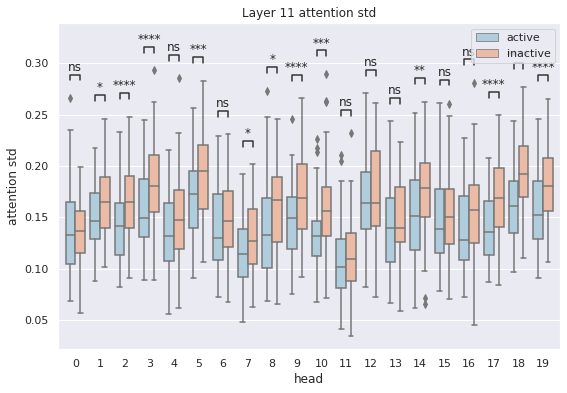

In [196]:
df_active = pd.DataFrame(active_layer11_std_dict)
df_inactive = pd.DataFrame(inactive_layer11_std_dict)

df_active = df_transformation(df_active)
df_inactive = df_transformation(df_inactive)

df_active['activity'] = 'active'
df_inactive['activity'] = 'inactive'

df = pd.concat([df_active, df_inactive]).reset_index(drop=True)

hue_order = ['active', 'inactive']

ax = sns.boxplot(x = 'head', y = 'attention std', hue = 'activity', hue_order = hue_order, palette = 'RdBu_r', data = df)
plt.title('Layer 11 attention std')
plt.legend()

add_stat = add_stat_annotation(ax, data=df.reset_index(drop=True), x='head', y='attention std', hue='activity', hue_order=hue_order, order=None,
                                       box_pairs=box_pairs,
                                       test='t-test_welch', text_format='star',
                                       loc='inside', verbose=2)

plt.show()

# Attention heat map

In [ ]:
# layer 9, 10, 11번의 Head 20개 std 확인 (Active)
active_layer9_std_dict = {}
active_layer10_std_dict = {}
active_layer11_std_dict = {}

for i in range(20):
    active_layer9_std_dict[i] = []
    active_layer10_std_dict[i] = []
    active_layer11_std_dict[i] = []

for attention in active_attentions:
    active_layer9_attention = attention[0]
    active_layer10_attention = attention[1]
    active_layer11_attention = attention[2]
    for i in range(20):
        active_layer9_std_dict[i].append(active_layer9_attention[i].std())
        active_layer10_std_dict[i].append(active_layer10_attention[i].std())
        active_layer11_std_dict[i].append(active_layer11_attention[i].std())

In [207]:
import random
from scipy.stats import entropy
check_attention = random.choice(active_attentions)

In [223]:
attention_heat_map = []
for layer in range(3):
    temp = []
    for head in range(20):
        temp.append(entropy(check_attention[layer][head]).mean())
    attention_heat_map.append(temp)

In [250]:
attention_heat_map = []
for layer in range(3):
    temp = []
    for head in range(20):
        temp.append(check_attention[layer][head].std())
    attention_heat_map.append(temp)

In [251]:
df = pd.DataFrame(np.array(attention_heat_map).transpose())
df.columns = ['0', '1', '2']
df.index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

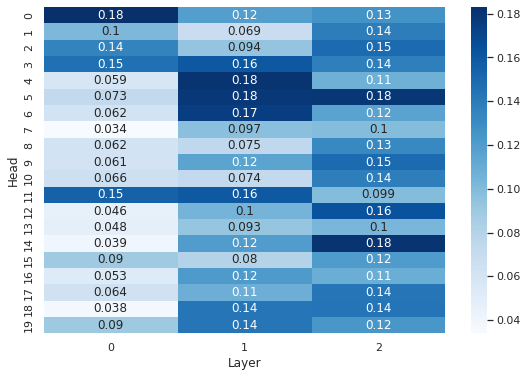

In [254]:
sns.heatmap(df, annot=True, cmap='Blues')
plt.xlabel('Layer', fontsize = 12)
plt.ylabel('Head', fontsize = 12)
plt.show()

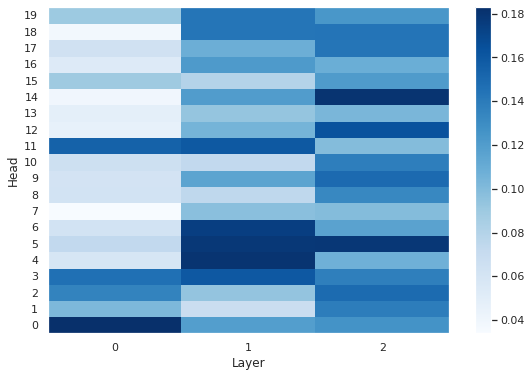

In [253]:
plt.pcolor(df, cmap='Blues')
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.colorbar()

plt.xlabel('Layer', fontsize = 12)
plt.ylabel('Head', fontsize = 12)
plt.show()

In [201]:
active_attentions
inactive_attentions

,attention std,head,activity
0,0.120565,0,active
1,0.103929,0,active
2,0.102100,0,active
3,0.109661,0,active
4,0.140552,0,active
...,...,...,...
3995,0.231987,19,inactive
3996,0.214992,19,inactive
3997,0.175686,19,inactive
3998,0.207924,19,inactive


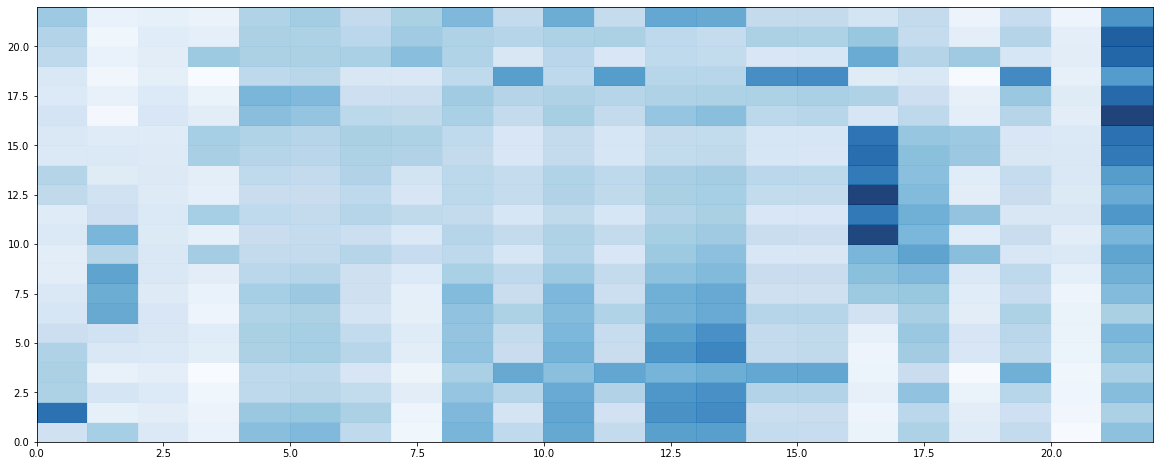

In [81]:
fig, ax = plt.subplots(figsize=(20, 8))
heatmap = ax.pcolor(attention[0][0][0].detach().numpy(), cmap=plt.cm.Blues, alpha=0.9)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt  # drawing heat map of attention weights


def plot_attention(data, X_label=None, Y_label=None):
    '''
      Plot the attention model heatmap
      Args:
        data: attn_matrix with shape [ty, tx], cutted before 'PAD'
        X_label: list of size tx, encoder tags
        Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8))  # set figure size
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)

    # Set axis labels
    if X_label != None and Y_label != None:
        #X_label = [x_label for x_label in X_label]
        #Y_label = [y_label for y_label in Y_label]

        xticks = range(0, len(X_label))
        ax.set_xticks(xticks, minor=False)  # major ticks
        ax.set_xticklabels(X_label, minor=False, rotation=45)  # labels should be 'unicode'

        yticks = range(0, len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor=False)  # labels should be 'unicode'

        ax.grid(True)

    # Save Figure
    plt.title(u'Attention Heatmap')
    file_name = './attention_heatmap.eps'
    print("Saving figures %s" % file_name)
    fig.savefig(file_name)  # save the figure to file
    plt.close(fig)  # close the figure
